This is a demostration on how to use Keras to to perform sentiment classification on the IMDB review dataset

My code will use unigram and bigram to vectorize the comments. It is essential to understand the basic training methods of NLP before using more advance pre-trained NLP packages such as BERT or XLnet

For more on BERT- https://arxiv.org/abs/1810.04805
published in 2018

in a nutshell, the traditional way of vectorizing language is using bigram, trigram etc. It is a forward looking conditional probability on predicting what the next word is going to be. However BERT pretrained model captures more context of a sentence by learning bidirectionally using the idea of MASKING the training matrix. However BERT lacks the forward or backward looking autoregressive mechanism.

For more on XLnet- https://arxiv.org/abs/1906.08237
published in 2019

XLnet by standing on the shoulders of BERT, it allowed the model to capture even more context by calculating the maximum likehood of all permutation in a sentence. It is not restricted only learning bidirectional context. It also incorporates the idea of Two-stream self-attention stream which allows the model to aware of both the context and the position of each token



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


print(pd.__version__)

Using TensorFlow backend.


0.25.3


In [3]:
# read in csv file directly from Keras public IMBD dataset

df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv", names=['comment', 'label'], header=0, encoding='utf-8')


In [4]:
df=pd.DataFrame(df)

In [5]:
df

,comment,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
# df=df1.sample(n=50000, random_state=23)
# Take a sample if necessary; for faster training

#check data format
print(df.iloc[0])

#check the labels in the dataset
df.label.value_counts()

#converts label into integer values
df['label'] = df.label.astype('category').cat.codes

#prints out dataframe
df

comment    One of the other reviewers has mentioned that ...
label                                               positive
Name: 0, dtype: object


,comment,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [7]:
#creates a new column for total words in each row, because we want to know the matrix dimenison.
df['total_words'] = df['comment'].str.count(' ') + 1

#prints the dataframe at the index of it's longest review
print(df.loc[df.total_words.idxmax()])

#prints the length of the longest view in the dataset
print("\nThe longest comment is " + str(df['total_words'].max()) + " words.\n")

comment        Match 1: Tag Team Table Match Bubba Ray and Sp...
label                                                          1
total_words                                                 2470
Name: 31481, dtype: object

The longest comment is 2470 words.



Let's visualize the movie review words length distribution.
By looking at the distribution the data scientist should have an estimation or an idea of many features or the caughtoff length for training
the reason being that long corpse (a movie review consisting of 2000 words) does not necessarily provide more context than a movie review that
consists of 500 words perse


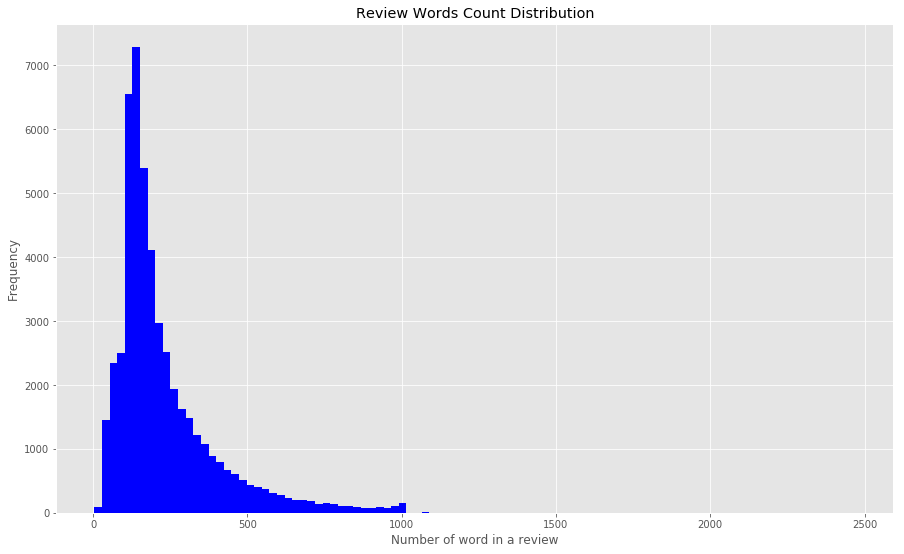

In [8]:
# plot word frequency

plt.figure(figsize=(15, 9))
plt.hist([(df['total_words'])],bins=100,color = "blue")
plt.xlabel('Number of word in a review')
plt.ylabel('Frequency')
plt.title('Review Words Count Distribution')
plt.show()

In [9]:
# counts the number of classes
# label the target feature

num_class = len(np.unique(df.label.values))
y = df['label'].values
print("\nThere are a total of " + str(num_class) + " classes.")

# evenly distributed dataset
df.groupby('label').count()


There are a total of 2 classes.


,comment,total_words
label,,
0,25000,25000
1,25000,25000


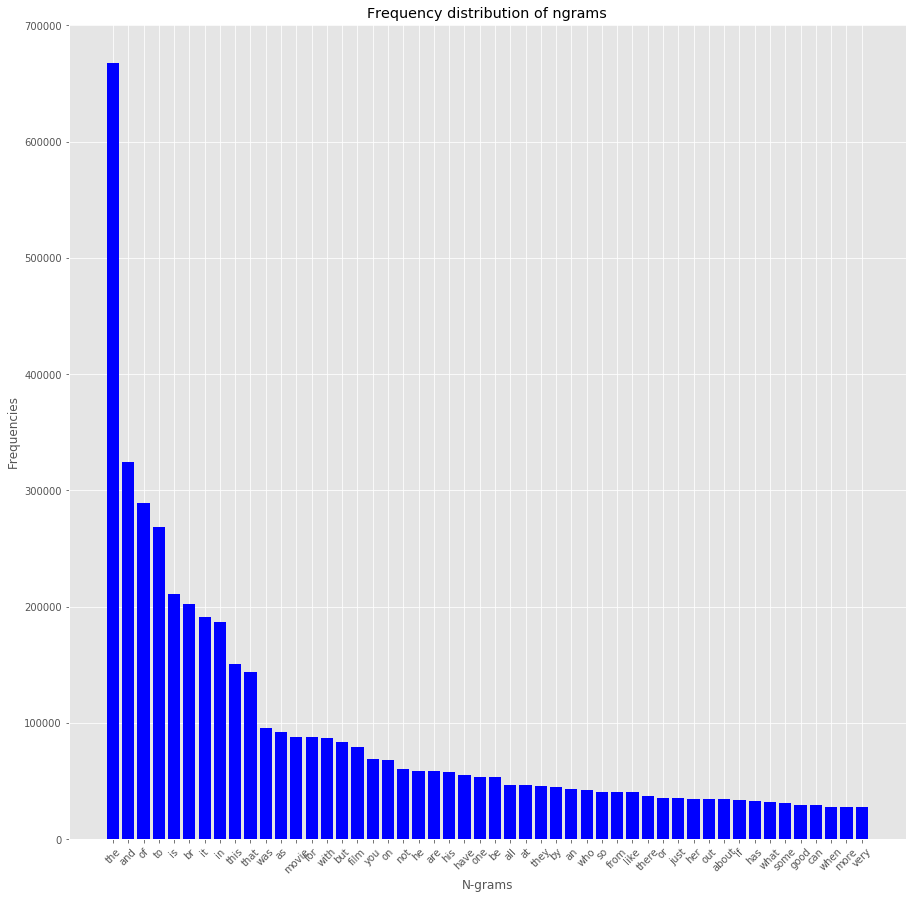

In [10]:
# import CountVectorizer to find common words used in the dataset
# the default CountVectorizer is unigram, which is what is needed in this situation to count the frequency of each words in the dataset

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

# transform and vectorize the comments in a sparse matrix. The dimenion length is the number of instances, the width of the matrix is the
# number of words in total corpse. The words that are not in the each review is padded with 0, hence the sparse matrix.

vect_texts = vectorizer.fit_transform(list(df['comment']))
all_ngrams = vectorizer.get_feature_names()

# display top min(50,len(all_ngrams) of the most frequent words
num_ngrams = min(50, len(all_ngrams))

# count the number of words in the total corpse
all_counts = vect_texts.sum(axis=0).tolist()[0]

# loop the words(features) with counts using zip function
all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(15, 15))
plt.bar(idx, counts, width=0.8, color = "blue")
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()


Some of these words are stop words, which provides no context or add any value in interpreting the sentiment of each review but be careful when deciding to manaually inserting stopwords. becareful not to just blindly remove top 50 frequent words, because words such as 'like', 'good', 'more' are a part of the top 50 most frequent words, however they do provide context to each review. stopwords do inflat the training matrix and should be removed for efficient training of the model. A common practise is to use nltk.corpus import stopwords package to skip tokenizing some of these words. The package is by no means perfec, data scientist should add additional stop words specific to the context and problem it's trying to solve.

In [11]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,f_classif, mutual_info_classif

# import a list of stopwords, when applied the stopwords in the corpose will not be tokenized, they will be skipped
stopwords=stopwords.words('english')

# min_df=2, any words that occurs less than 2 times in the total corpse will not be tokenized

vectorizer = TfidfVectorizer(min_df=3, binary=True, analyzer='word',ngram_range= (1,2), stop_words=stopwords)
df_bigram = vectorizer.fit_transform(df['comment'])


We use TfidfVectorizer directly instead of countvectorizer to assign weights directly to each word based on their frequency. The more frequent the words are the less weight will be assigned to the word. This allows the Neural network to learn more context that matters

For more on inverse document-frequency equation:
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

n is the total frequency of a word in a particular document set (in one particular movie review)

df(t) is count of the word occuring in the entire document at least once ( for example, the number of time the word 'the' is **contained** in the entire 50000 review)

then the resulting vectors are nomralized by the Eucildean Norm, this is where the weight actually get reduced to 0, when it's very frequent.

With Smoothing, it allows the algothrim to calculate idf value even when in the testing dataset the word it is not seen.

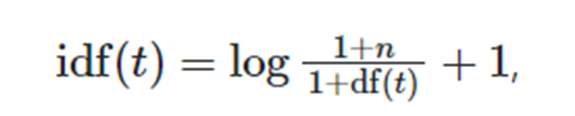


without smoothing, if not seen in testing it will result in undefined idf value


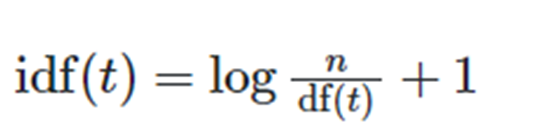

In [12]:
# There a few ways of selecting the number of words to be included in the training set
# you can use Chi2, f_classif
# specify the k features to be included in the training
# the k features (the width of the matrix) will correspond to the number of unique words and/or phrases (if using bigram or trigram etc)
# to be included in the the training set
# Chi2, f_classif and mutual_info_classif with all the same k-value will produce different sets of words to be included in the training dataset based on their calculation.
# another way of putting it is that the dimensions are the same, but the sparseness or the number of features selected to be a part of the 1800 features will be different
# personally I prefer chi2 (it's a measurement of feature dependency to the target, the higher the value the more relevant) as it produces a more dense matrix than f_classif

k=26000

selector = SelectKBest(chi2, k=min(k, df_bigram.shape[1]))
selector.fit(df_bigram, df.label)
transformed_texts = selector.transform(df_bigram).astype('float32')

In [13]:
# there are 3.2 million elements (non zero elemets) in the matrix
# they are words and phrases that are tokenized with idf weighting, this directly impacts training accuracy and speed
transformed_texts

<50000x26000 sparse matrix of type '<class 'numpy.float32'>'
	with 3204039 stored elements in Compressed Sparse Row format>

In [14]:
# keep the matrix compressed in this case, you will get memorry error if you are trying to print the array. Kaggle only allocates 8gb of ram
transformed_texts=transformed_texts.toarray()

In [15]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(transformed_texts, y, test_size=0.3)

In [16]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers

#builds input shape

# This a fully connected network with number of total parameters = 1,668,354   
# 2 hidden layers, with a droput of 0.5
# relu is the activation function, sigmoid also works well in this case since there are not too many layers to diminish the learn rate
# output function is sigmoid which is the same if you use softmax in a binary situation
# training on entropy, RMS and accuracy

max_features = min(k, df_bigram.shape[1])

model = Sequential()
model.add(Dense(64, input_dim=max_features, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['acc'])


# prints out summary of model
model.summary()

# saves the model weights
# the train/validation/test split is 26500/8750/15000, it's essential to hold out a decent chunck of unseen data
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=15, callbacks=[checkpointer])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1664064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 1,668,354
Trainable params: 1,668,354
Non-trainable params: 0
_________________________________________________________________
Train on 26250 samples, validate on 8750 samples
Epoch 1/15
26250/26250 [==============================] - 5s 

1. total number of parameters in the network is 1,668,354 (not the number of inputs)

first hidden layer

(26000 x 64) + 64 which is first hidden layer itself = 1664064

second hidden layer
(64 x 64) + 64 which is the second hidden layer itself = 4160

output layer

(64 x 2) + 2 which is the output layer itself = 130

in total it's 1,668,354

But it reality the number of parameters should only be about a half because of the dropout rates


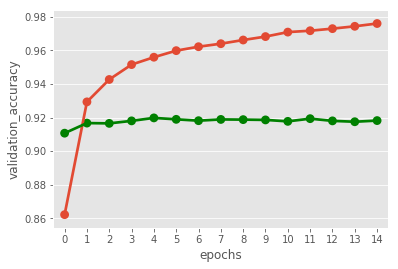

In [17]:
#plot model
df_result = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df_result, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df_result, fit_reg=False, color='green')

As we can see from the training validation chart the model is overfitting. The training set is approach nearly perfect accuracy. This is not necessary a bad thing. Initially we want the model to overfitt. Overfitting it good in the sense that there are a lot of tools to tapper overfitting. At least the availablity of data is not the barrier.

In this case we can even use:

1. A even higher dropout rate, it seems that the neurons are still learning specific weights of some words/phrases. But when dropout rate is too high, the model does lose accuracy

2. Smaller batch size

3. Higher L2 regulization, similar effect to dropout


Overfitting it's a reflection of inefficiency in feature selection in this case, but as long as validation accuracy and testing accuracy are stable the model is a good shape.


In [18]:
#get prediction accuarcy for testing dataset 15000 samples
predicted = model.predict(X_test)
predicted_best = np.argmax(predicted, axis=1)
print (accuracy_score(predicted_best, y_test))
predicted=pd.DataFrame(data=predicted)

0.9245333333333333


In [19]:
print (classification_report(predicted_best, y_test))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      7448
           1       0.93      0.92      0.92      7552

    accuracy                           0.92     15000
   macro avg       0.92      0.92      0.92     15000
weighted avg       0.92      0.92      0.92     15000



currently there are a couple of industy leading models in the space of NLP

BERT and XLnet